# Transfer Learning for Image Classification using Torchvision, Pytorch and Python

This code is an implementation of the program provided by a tutorial on how to do image classification on the GTSRB dataset (https://curiousily.com/posts/transfer-learning-for-image-classification-using-torchvision-pytorch-and-python/). Small adjustments was made according to a tutorial on how to do adversarial attacks in Pytorch(https://adversarial-ml-tutorial.org/adversarial_examples/). The project was created during an Deep Learning course on autnoumous vehicles at Umeå University. Most of the code was given by the course. Author of the alternation of this code is Maximilian Törnqvist.

This implementation uses a pre-trained ResNet to classify images of traffic signs. The images of traffic signs being used is the images from the GTSRB dataset. In this implementation, the model is being trained on all of the classes of the dataset. Later on, the images in the testset is perturbated using adversarial attacks. This is done to as an exercise to explore the consequences of adversarial attacks and to show the vulnerability of neural networks and non-linear models.

In [ ]:
!nvidia-smi

Fri May  7 17:07:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   1968MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##Downloading dataset of traffic signs

The [German Traffic Sign Recognition Benchmark (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) contains more than 50,000 annotated images of 40+ traffic signs. The task is to given an image, recognize the given traffic sign on the image.



In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2021-05-07 17:07:52--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip.2’

GTSRB_Final_Trainin 100%[===================>] 263.50M  12.7MB/s    in 19s     

2021-05-07 17:08:12 (13.7 MB/s) - ‘GTSRB_Final_Training_Images.zip.2’ saved [276294756/276294756]

replace GTSRB/Final_Training/Images/00000/00000_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Exploration

The images for each traffic sign are stored in a separate directory. How many do we have?

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

We'll create 3 helper functions that use OpenCV and Torchvision to load  and show images:

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Let's have a look at some examples for each of the traffic sign examples:

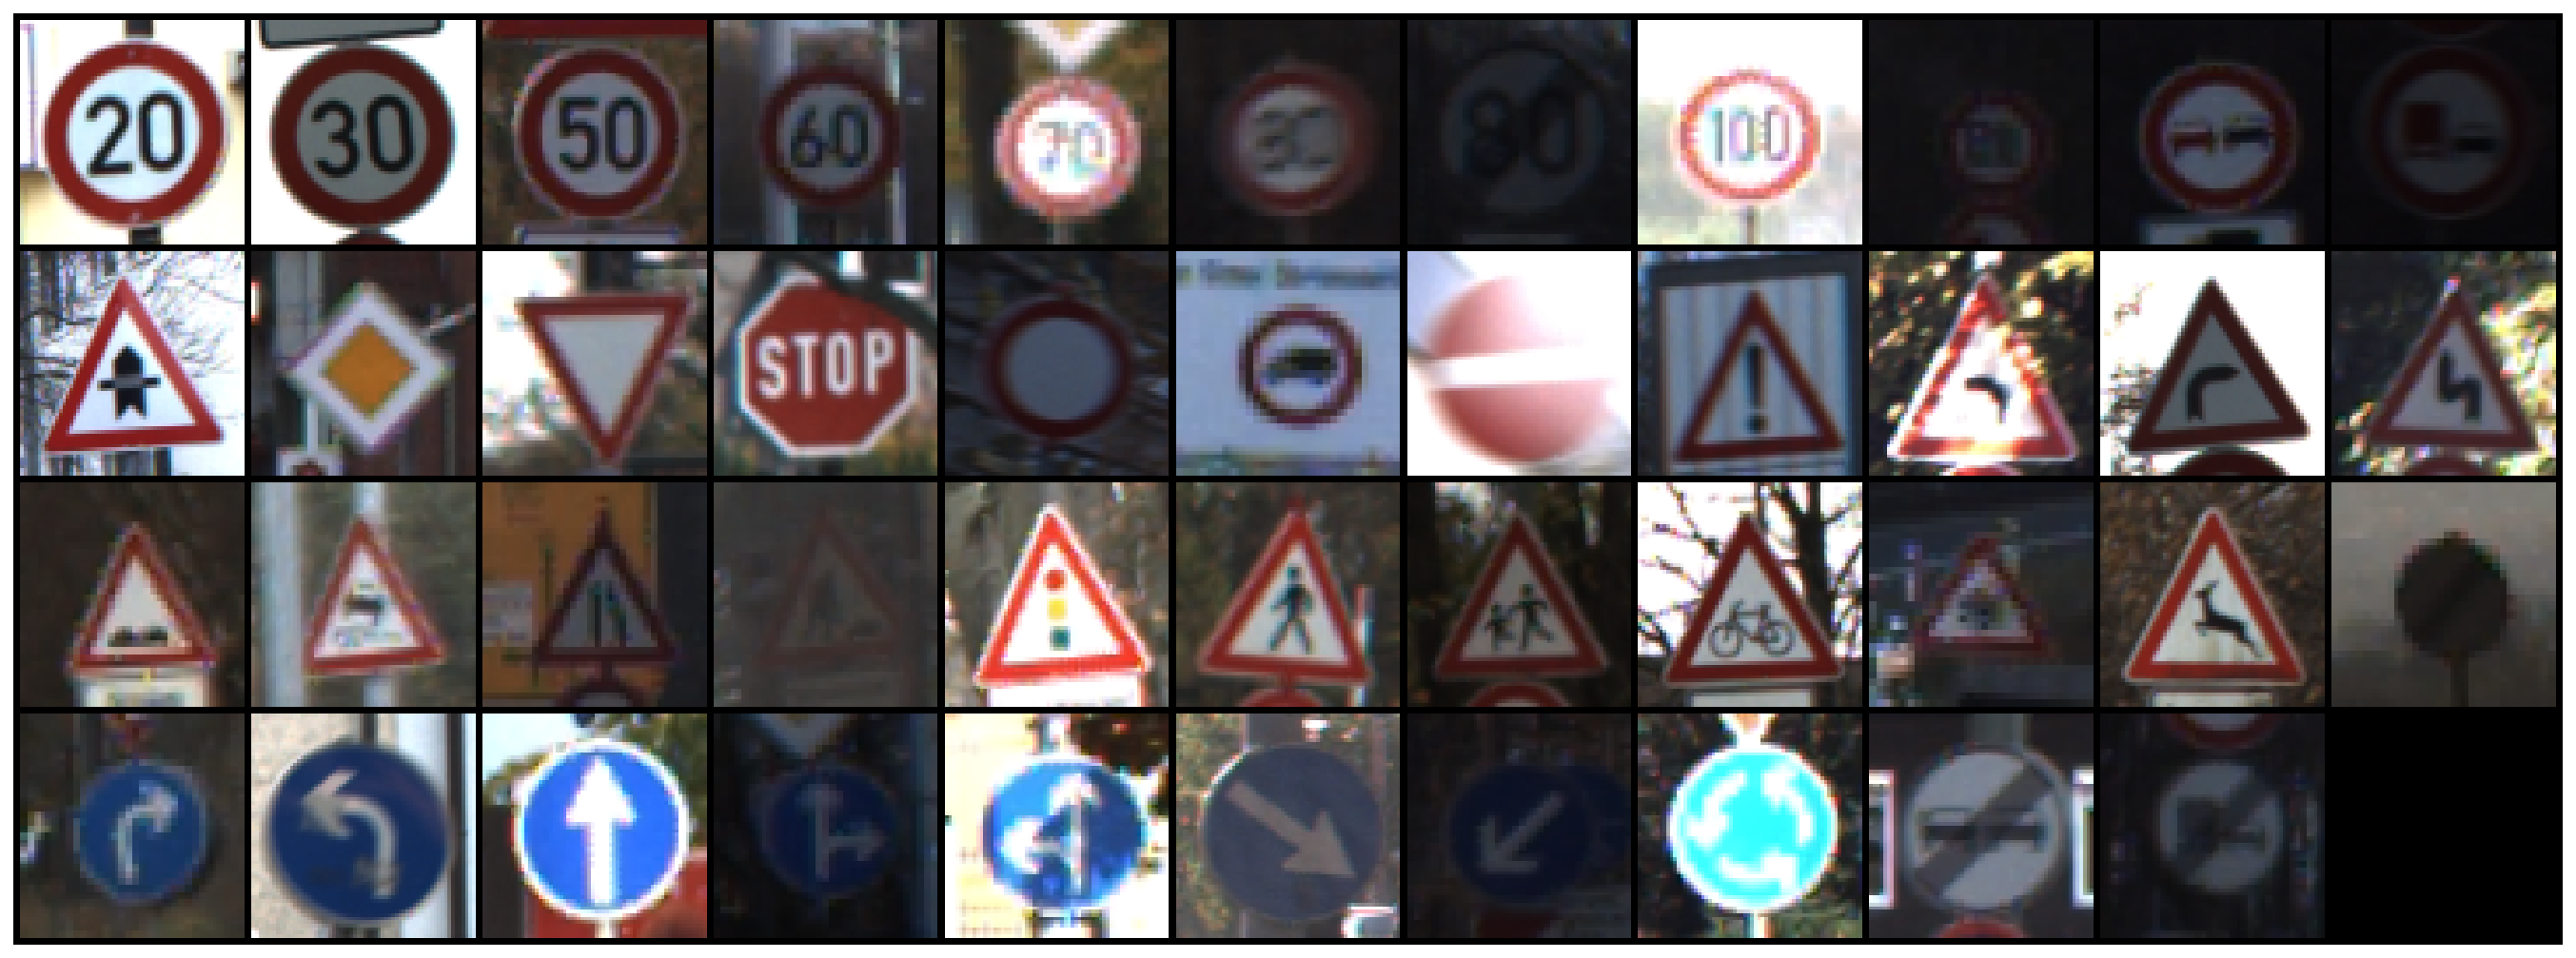

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

And here is a single sign:

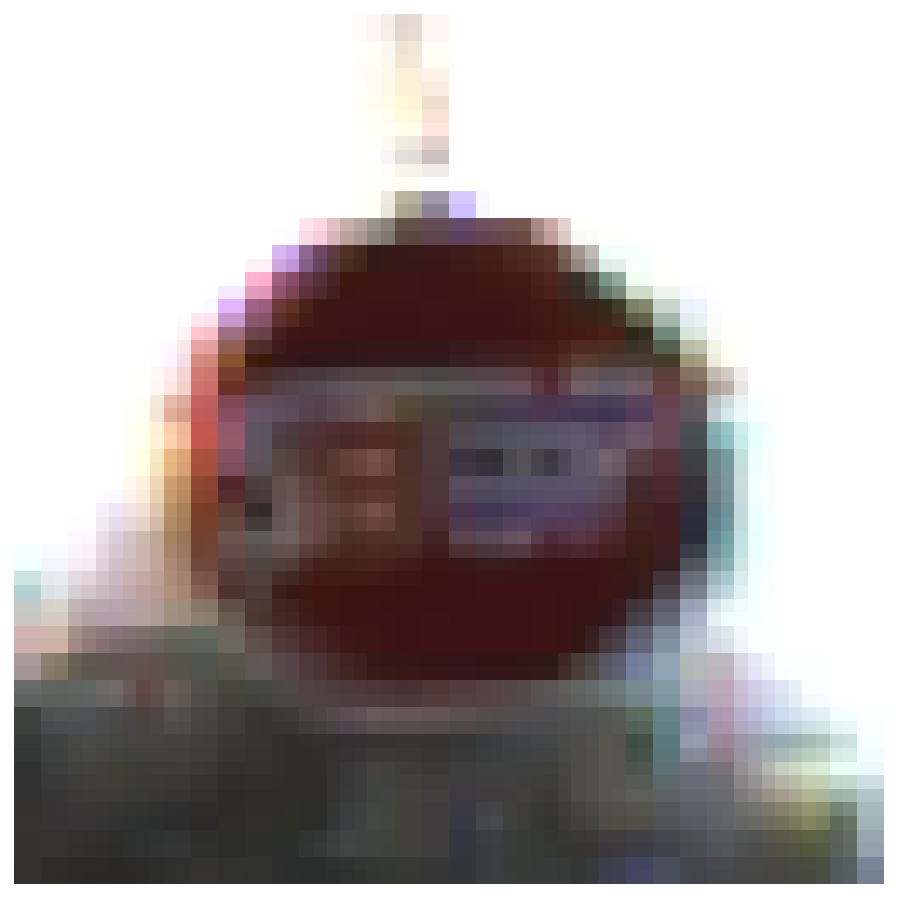

In [ ]:
img_path = glob(f'{train_folders[14]}/*ppm')[1]

show_image(img_path)

## Building a dataset

Due to training time the number of classes has been restricted. The number of the range should be extended to the number of classes in GTSRB if use of all classes is requested.

In [ ]:
class_names = []
class_indices = []

for i in range(5):
  class_names.append(str(i))
  class_indices.append(i)

We'll copy the images files to a new directory, so it's easier to use the Torchvision's dataset helpers. Let's start with the directories for each class:

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

We'll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We'll copy each image to the correct dataset directory:

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

0: 210
1: 2220
2: 2250
3: 1410
4: 1980


We have some class imbalance, but it is not that bad. We'll ignore it.

We'll apply some image augmentation techniques to artificially increase the size of our training dataset:

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

We apply some random resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel. This is a [requirement of the pre-trained models](https://pytorch.org/docs/stable/torchvision/models.html) in Torchvision.

We'll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We'll also store the number of examples in each dataset and class names for later:

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 807, 'train': 6456, 'val': 807}

Let's have a look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


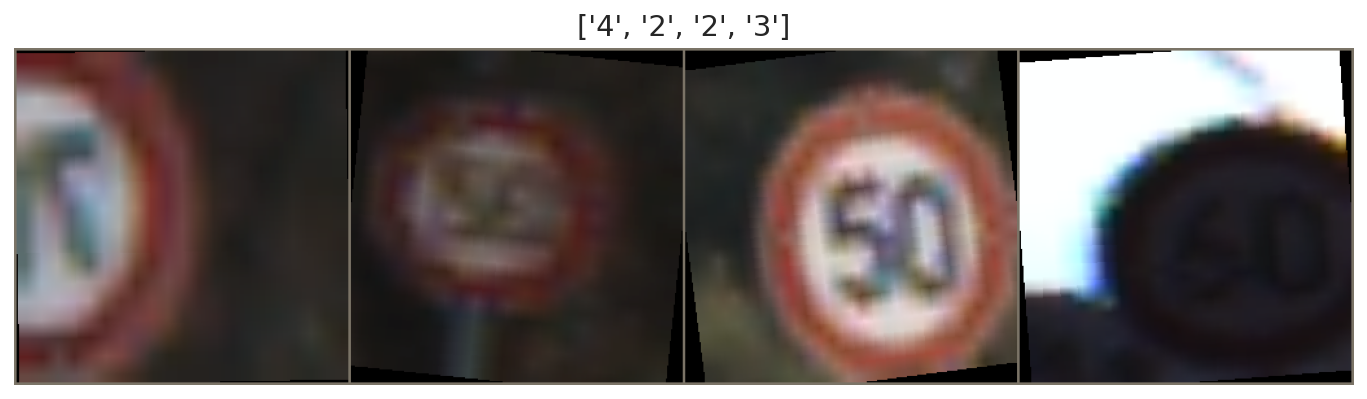

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using a pre-trained model:

Our model will receive raw image pixels and try to classify them into one of four traffic signs. How hard can it be? Try to build a model from scratch.

Here, we'll use [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) to copy the architecture of the very popular [ResNet](https://arxiv.org/abs/1512.03385) model. On top of that, we'll use the learned weights of the model from training on the [ImageNet dataset ](http://www.image-net.org/). All of this is made easy to use by Torchvision:

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Let's create an instance of our model:

In [ ]:
base_model = create_model(len(class_names))

### Training

We'll write 3 helper functions to encapsulate the training and evaluation logic. Let's start with `train_epoch`:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

We start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

Note that we're also using a learning rate scheduler (more on that later).

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is pretty similar, except that we don't do any gradient calculations.

Let's put everything together:

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

We do a lot of string formatting and recording of the training history. The hard stuff gets delegated to the previous helper functions. We also want the best model, so the weights of the most accurate model(s) get stored during the training.

Let's train our first model:

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.7802818347497981 accuracy 0.715458488228005
Val   loss 0.14158351886092505 accuracy 0.9541511771995044

Epoch 2/3
----------
Train loss 0.32018586802675736 accuracy 0.880731102850062
Val   loss 0.028463879325517884 accuracy 0.9925650557620818

Epoch 3/3
----------
Train loss 0.28756742184565376 accuracy 0.88909541511772
Val   loss 0.06737730250507852 accuracy 0.9826517967781908

Best val accuracy: 0.9925650557620818
CPU times: user 2min 15s, sys: 50.7 s, total: 3min 6s
Wall time: 3min 11s


Here's a little helper function that visualizes the training history for us:

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

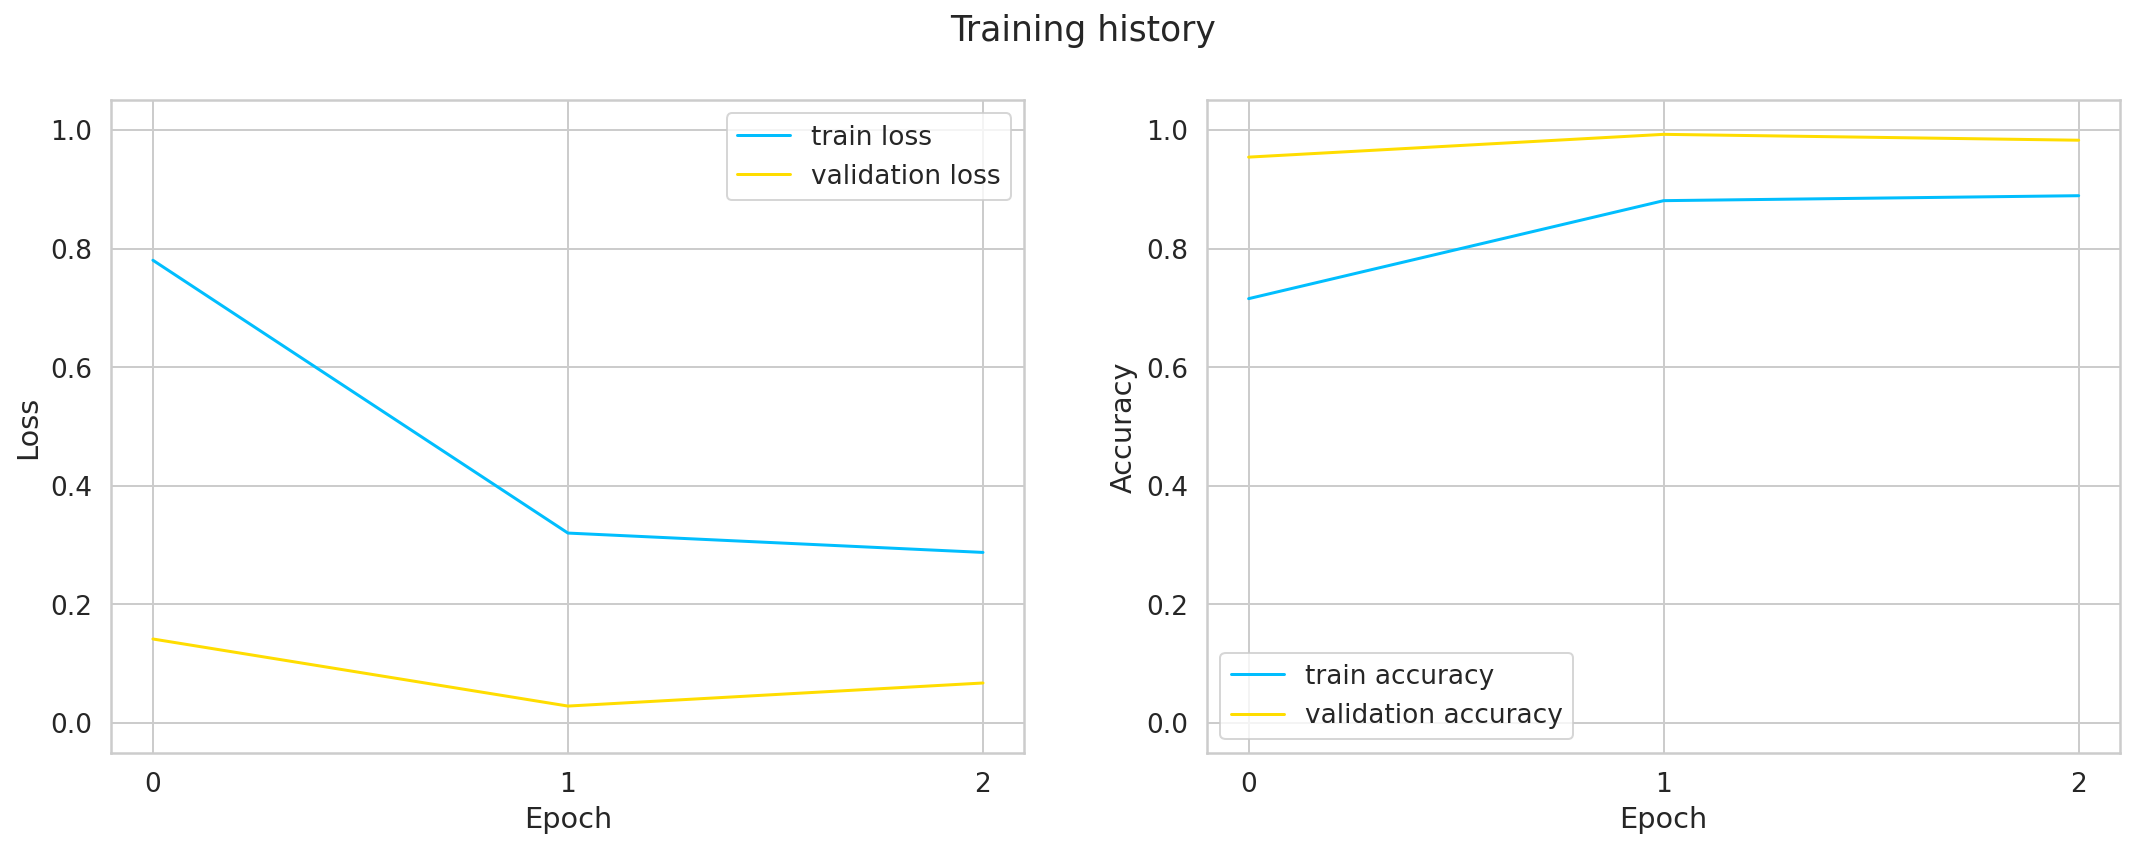

In [ ]:
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 3 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

### Evaluating the network after and before adversarial attacks
*Warning! This code includes uneccassary repetition of code, which could and should be compressed to a more concentrated program. The reason why this has been left in the code is due to a restriction of access to Google's GPUs and TPUs which lead to a extended training time and a lack of time to fix the apperance of reptition in the code.*

In [ ]:
def show_original_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return

In [ ]:
def fgsm(model, X, y, epsilon):
    print(X.shape)
    print(X.dtype)
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    print(delta.shape)
    print(delta.dtype)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def show_fgsm_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = fgsm(model, inputs, labels, 0.1)
      outputs = model(inputs + delta)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()
  
def show_pgd_linf_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = pgd_linf(model, inputs, labels, epsilon=0.1, alpha=1e-2, num_iter=40)
      outputs = model(inputs + delta)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()
  
def show_pgd_linf_target_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

    #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = pgd_linf_targ(model, inputs, labels, epsilon=0.1, alpha=1e-2, num_iter=40, y_targ=3)
      outputs = model(inputs + delta)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def show_pgd_linf_target_predictions2(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = pgd_linf_targ2(model, inputs, labels, epsilon=0.12, alpha=1e-2, num_iter=40, y_targ=4)
      outputs = model(inputs + delta)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return


#Showing images and the predicitions of the models
Here we can see how well the attacks performs in terms of how good it seems to missguide the model in it's predicitions. It's worth acknowledging the fact that these targeted adversarial attacks in some cases also is done on images that belongs to the targeted class.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


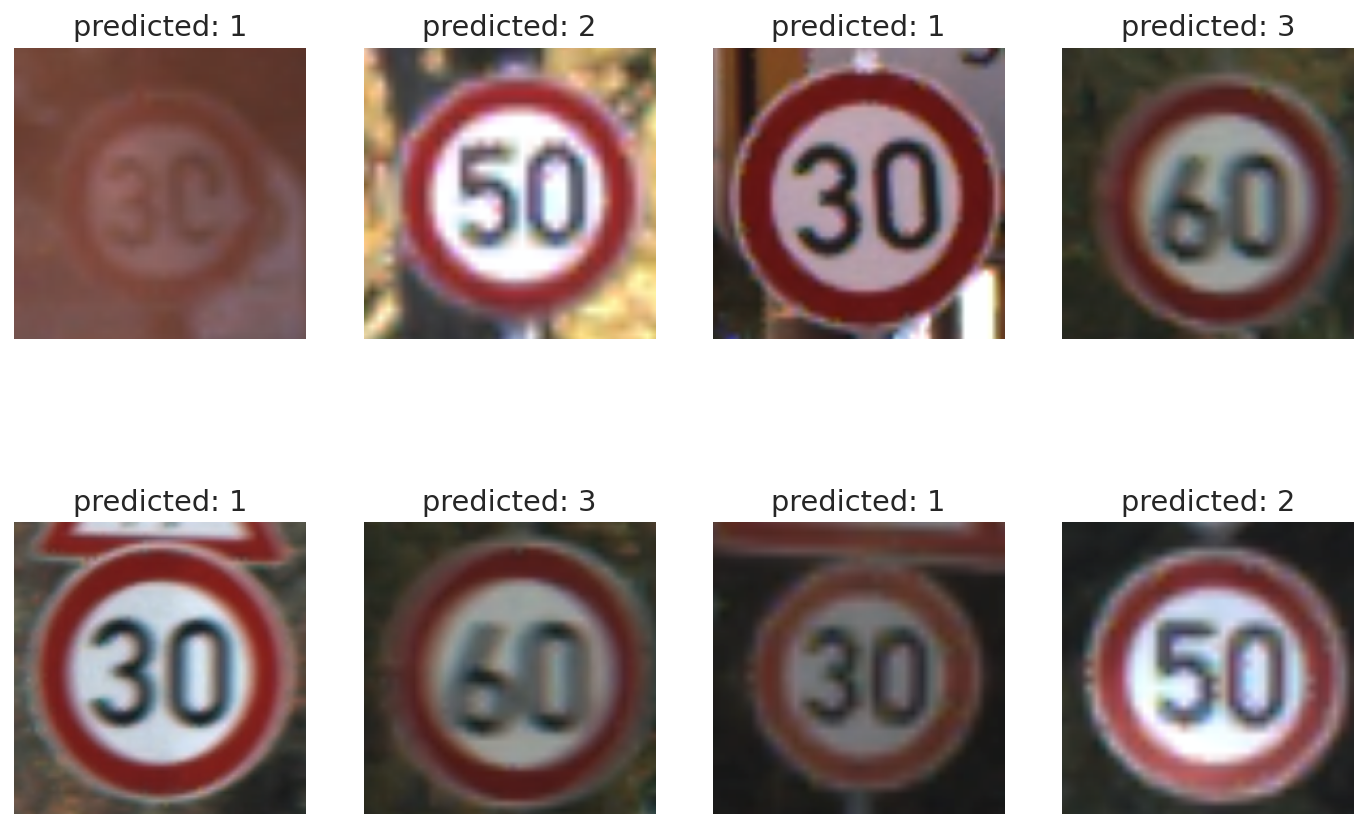

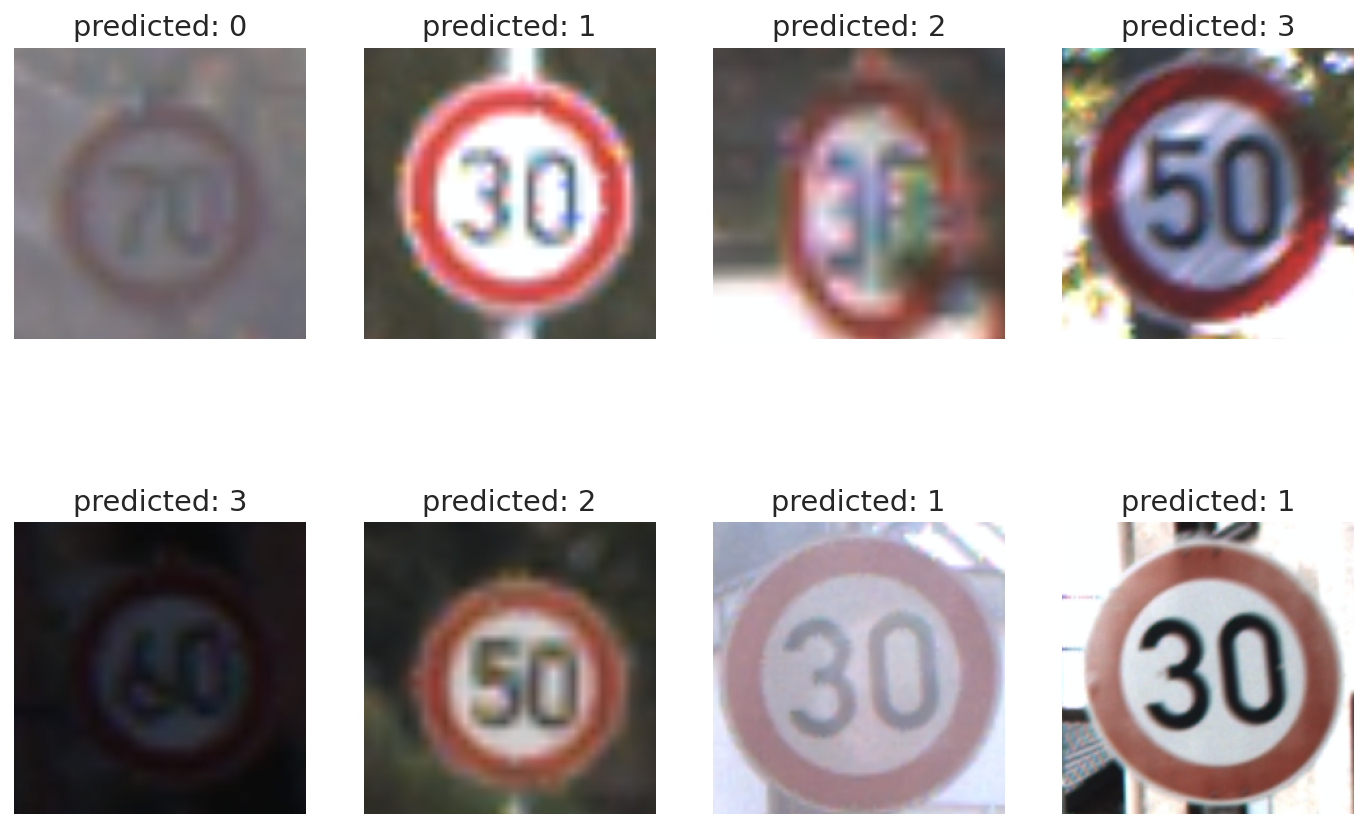

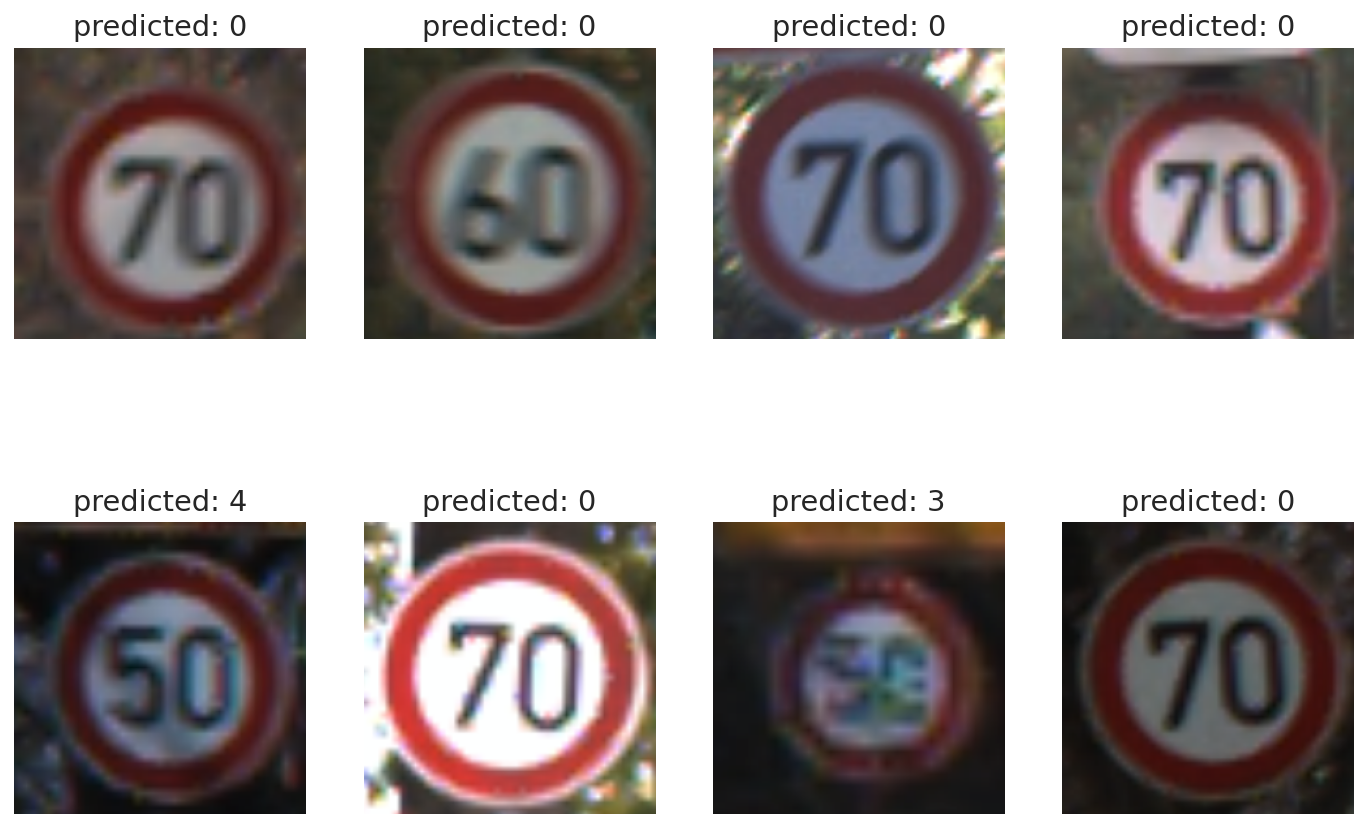

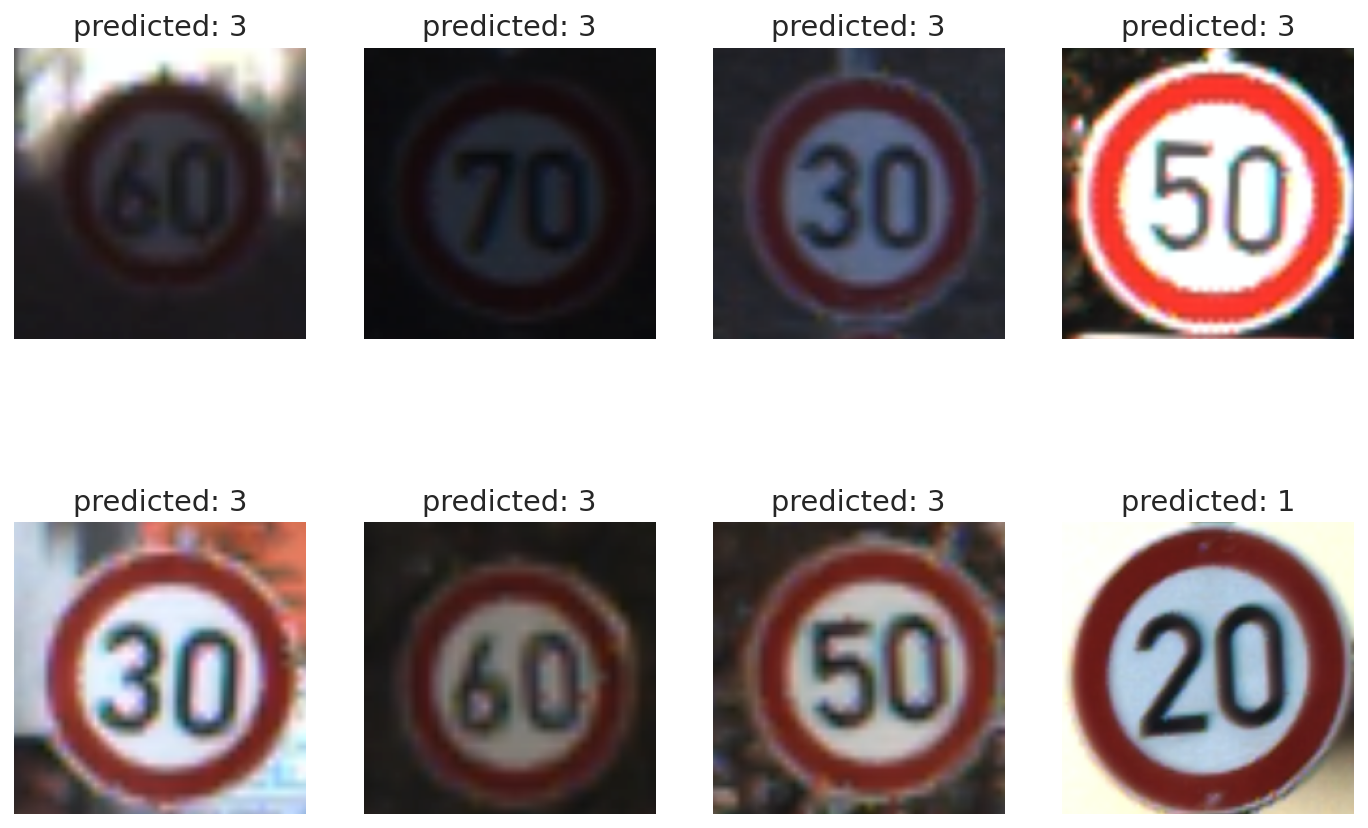

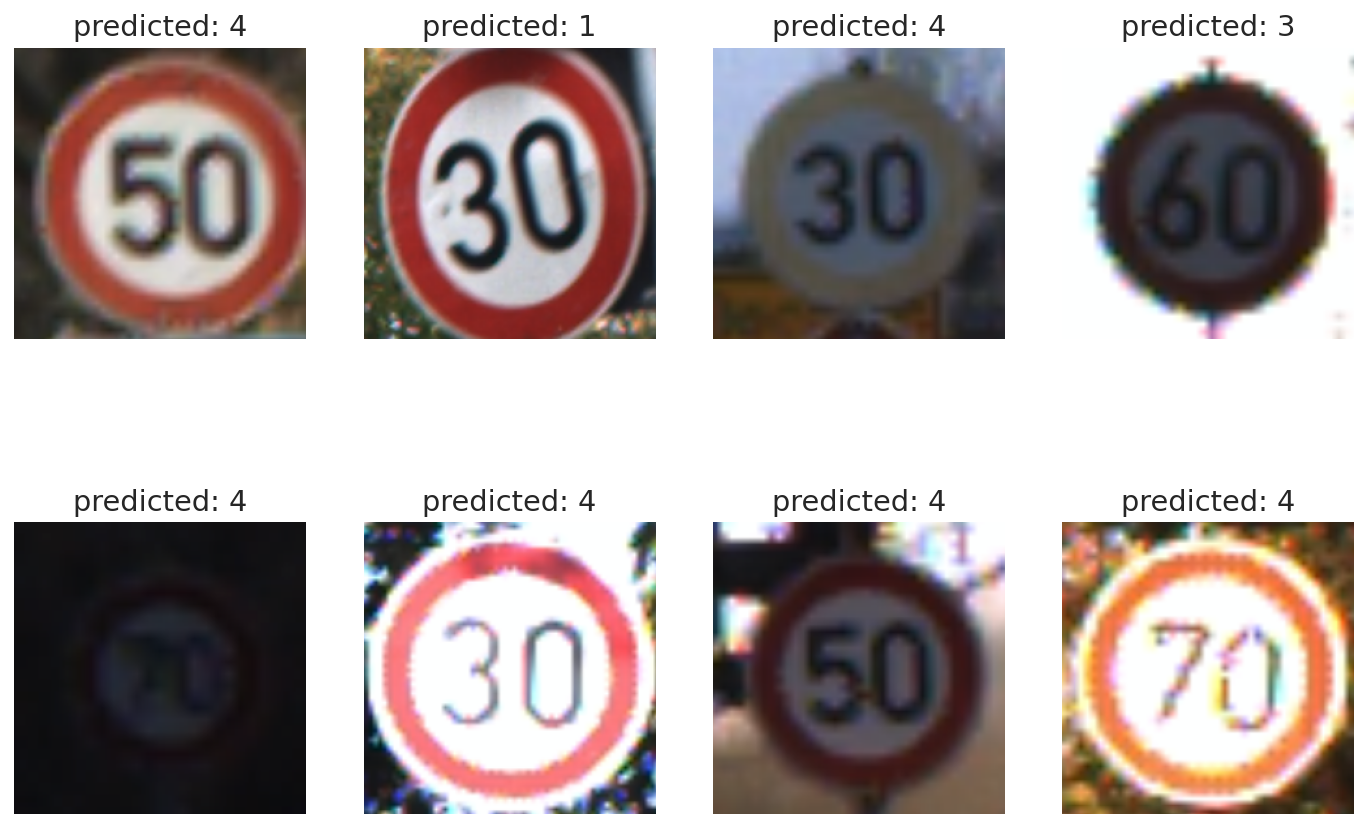

In [ ]:
show_original_predictions(base_model, class_names, n_images=8)
show_fgsm_predictions(base_model, class_names, n_images=8)
show_pgd_linf_predictions(base_model, class_names, n_images=8)
show_pgd_linf_target_predictions(base_model, class_names, n_images=8)
show_pgd_linf_target_predictions2(base_model, class_names, n_images=8)

#Get the predictions
Down below we attack the images with the help of different functions for adversarial attacks from https://adversarial-ml-tutorial.org/adversarial_examples/. After the attack we let the model predict the correct label of the images.

In [ ]:
def get_original_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def get_predictions_fgsm(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = fgsm(model, inputs, labels, 0.1)
      outputs = model(inputs+delta)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def get_predictions_pgd_linf(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = pgd_linf(model, inputs, labels, 0.1, 1e-2, 40)
      outputs = model(inputs+delta)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def get_predictions_pgd_linf_target(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = pgd_linf_targ(model, inputs, labels, 0.1, 1e-2, 40, y_targ=3)
      outputs = model(inputs+delta)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def get_predictions_linf_target2(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  #with torch.no_grad():
  with torch.set_grad_enabled(True):
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      delta = pgd_linf(model, inputs, labels, 0.2, 1e-2, 40, y_targ=4)
      outputs = model(inputs+delta)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred1, y_test1 = get_predictions_fgsm(base_model, data_loaders['test'])
y_pred2, y_test2 = get_predictions_pgd_linf(base_model, data_loaders['test'])
y_pred3, y_test3 = get_predictions_pgd_linf_target(base_model, data_loaders['test'])
y_pred4, y_test4 = get_predictions_pgd_linf_target(base_model, data_loaders['test'])
y_pred5, y_test5 = get_original_predictions(base_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Print the performance on the adversarial attacks
In the code below we can see how well the model does on images attacked by different algorithms for adversarial attacks. We also print the performance on the non-attacked images, which lets us see and compare how much the adversarial attacks can affect the performance of non-linear classification models.

In [ ]:
print("FGSM PERFORMANCE:\n")
print(classification_report(y_test1, y_pred1, target_names=class_names))
print("PGD_LINF PERFORMANCE:\n")
print(classification_report(y_test2, y_pred2, target_names=class_names))
print("PGD_LINF_TARG PERFORMANCE:\n")
print(classification_report(y_test3, y_pred3, target_names=class_names))
print("PGD_LINF_TARG2 PERFORMANCE:\n")
print(classification_report(y_test4, y_pred4, target_names=class_names))
print("ORIGINAL PERFORMANCE:\n")
print(classification_report(y_test5, y_pred5, target_names=class_names))

FGSM PERFORMANCE:

              precision    recall  f1-score   support

           0       0.12      0.86      0.21        21
           1       0.76      0.71      0.73       222
           2       0.61      0.53      0.57       225
           3       0.42      0.54      0.47       141
           4       0.74      0.25      0.38       198

    accuracy                           0.52       807
   macro avg       0.53      0.58      0.47       807
weighted avg       0.64      0.52      0.54       807

PGD_LINF PERFORMANCE:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.05      0.02      0.03       222
           2       0.04      0.03      0.04       225
           3       0.00      0.00      0.00       141
           4       0.00      0.00      0.00       198

    accuracy                           0.01       807
   macro avg       0.02      0.01      0.01       807
weighted avg       0.02      0.01  